In [26]:
from experiments.backtest import TRADING_DAYS
from qresearch.backtest.metrics import perf_summary
from qresearch.backtest.portfolio import backtest_weights
from qresearch.data import download_close, download_ohlc
import pandas as pd
import numpy as np
from dataclasses import dataclass

@dataclass(frozen=True)
class SingleAssetTimingConfig:
    asset: str = "SPY"
    ma_window: int = 200
    risk_on_weight: float = 1.0          # can be <1 for de-risking
    use_safe_asset: bool = True
    safe_asset: str = "BIL"              # or "SHY"
    rebalance_every: int = 1             # 1=daily, 5=weekly


def _rebalance_mask(index: pd.DatetimeIndex, every: int) -> pd.Series:
    if every <= 1:
        return pd.Series(True, index=index)
    m = np.zeros(len(index), dtype=bool)
    m[::every] = True
    return pd.Series(m, index=index)


def build_single_asset_timing_weights(prices: pd.DataFrame, cfg: SingleAssetTimingConfig) -> pd.DataFrame:
    """
    Decision-time weights as-of close t (UNSHIFTED).
    backtest_weights() will shift(1) to apply next day.
    """
    prices = prices.sort_index()

    cols = [cfg.asset] + ([cfg.safe_asset] if cfg.use_safe_asset else [])
    missing = [c for c in cols if c not in prices.columns]
    if missing:
        raise ValueError(f"prices missing columns: {missing}")

    px = prices[cfg.asset]
    ma = px.rolling(cfg.ma_window, min_periods=cfg.ma_window).mean()
    signal_on = (px > ma).fillna(False)  # True means risk-on at close t

    do_rebal = _rebalance_mask(prices.index, cfg.rebalance_every)

    w = pd.DataFrame(0.0, index=prices.index, columns=cols)

    # carry-forward to reduce churn if rebalance_every > 1
    last = w.iloc[0].copy()

    for dt in prices.index:
        if not do_rebal.loc[dt]:
            w.loc[dt] = last.values
            continue

        if bool(signal_on.loc[dt]):
            w.loc[dt, cfg.asset] = cfg.risk_on_weight
            if cfg.use_safe_asset:
                w.loc[dt, cfg.safe_asset] = 0.0
        else:
            w.loc[dt, cfg.asset] = 0.0
            if cfg.use_safe_asset:
                w.loc[dt, cfg.safe_asset] = 1.0  # park in bills
            # if not using safe asset, residual goes to cash in your backtester

        last = w.loc[dt].copy()

    return w


# --- usage ---
tickers = ["SPY", "BIL"]
prices = download_close(tickers, start="2005-01-01", end=None)  # your function
cfg = SingleAssetTimingConfig(asset="SPY", ma_window=200, use_safe_asset=True, safe_asset="BIL", rebalance_every=1)
weights = build_single_asset_timing_weights(prices, cfg)
res = backtest_weights(prices=prices[weights.columns], weights=weights, fee_bps=2.0, rf_annual=0.0)

In [28]:
from typing import Optional, Sequence, Tuple


# ---------- Config ----------
@dataclass(frozen=True)
class IBSLowerBandTimingConfig:
    asset: str = "SPY"
    safe_asset: Optional[str] = "BIL"   # set None if you want cash residual instead

    # Step (1): avg range
    range_ma_window: int = 25

    # Step (2): IBS
    ibs_threshold: float = 0.30

    # Step (3): lower band params
    high_lookback: int = 10
    band_k: float = 2.5

    # Step (6): stop filter
    sma_stop_window: int = 300

    # Execution controls
    risk_on_weight: float = 1.0
    rebalance_every: int = 1            # 1=daily, 5=weekly-ish


# ---------- Helpers to extract OHLC ----------
def _get_ohlc_from_df(
    ohlc: pd.DataFrame,
    ticker: str,
) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    Accepts either:
    1) MultiIndex columns: (field, ticker) e.g. ('High','SPY'), ('Low','SPY'), ('Close','SPY')
    2) Flat columns: 'SPY_High', 'SPY_Low', 'SPY_Close' (also accepts 'Adj Close' variants)

    Returns: (high, low, close) as Series indexed by date.
    """
    if not isinstance(ohlc.index, pd.DatetimeIndex):
        raise TypeError("ohlc.index must be a DatetimeIndex")

    # Case 1: MultiIndex columns
    if isinstance(ohlc.columns, pd.MultiIndex):
        def pick(field: str) -> pd.Series:
            if (field, ticker) in ohlc.columns:
                return ohlc[(field, ticker)]
            # common alternative naming
            if field == "Close" and ("Adj Close", ticker) in ohlc.columns:
                return ohlc[("Adj Close", ticker)]
            raise KeyError(f"Missing column ({field}, {ticker}) in ohlc DataFrame")
        high = pick("High")
        low = pick("Low")
        close = pick("Close")
        return high, low, close

    # Case 2: flat columns
    candidates = [
        (f"{ticker}_High", f"{ticker}_Low", f"{ticker}_Close"),
        (f"{ticker}_high", f"{ticker}_low", f"{ticker}_close"),
        (f"{ticker} High", f"{ticker} Low", f"{ticker} Close"),
    ]
    for hcol, lcol, ccol in candidates:
        if hcol in ohlc.columns and lcol in ohlc.columns and ccol in ohlc.columns:
            return ohlc[hcol], ohlc[lcol], ohlc[ccol]

    # allow Adj Close
    adj_candidates = [
        (f"{ticker}_High", f"{ticker}_Low", f"{ticker}_Adj Close"),
        (f"{ticker}_High", f"{ticker}_Low", "Adj Close"),
    ]
    for hcol, lcol, ccol in adj_candidates:
        if hcol in ohlc.columns and lcol in ohlc.columns and ccol in ohlc.columns:
            return ohlc[hcol], ohlc[lcol], ohlc[ccol]

    raise KeyError(
        f"Could not find OHLC columns for ticker={ticker}. "
        f"Expected MultiIndex (field,ticker) or flat columns like '{ticker}_High', '{ticker}_Low', '{ticker}_Close'."
    )


def _rebalance_mask(index: pd.DatetimeIndex, every: int) -> pd.Series:
    if every <= 1:
        return pd.Series(True, index=index)
    m = np.zeros(len(index), dtype=bool)
    m[::every] = True
    return pd.Series(m, index=index)


# ---------- Core: build decision weights ----------
def build_ibs_lowerband_timing_weights(
    ohlc: pd.DataFrame,
    prices_close: pd.DataFrame,
    cfg: IBSLowerBandTimingConfig,
) -> pd.DataFrame:
    """
    Build decision-time weights as-of close t (UNSHIFTED).
    Your backtest_weights() will apply shift(1) internally.

    Inputs
    ------
    ohlc: DataFrame containing High/Low/Close for cfg.asset (see _get_ohlc_from_df)
    prices_close: close-price DataFrame (date x ticker) for backtest (must include cfg.asset and optionally cfg.safe_asset)

    Notes
    -----
    Entry (Step 4): Close < lower_band AND IBS < threshold AND Close >= SMA300
    Exit  (Step 5): if in position and Close > High[t-1], then flat
    Stop  (Step 6): if Close < SMA300, flat (and block entry)
    """
    # validate close prices availability for backtest
    needed = [cfg.asset] + ([cfg.safe_asset] if cfg.safe_asset else [])
    missing = [c for c in needed if c not in prices_close.columns]
    if missing:
        raise ValueError(f"prices_close missing columns required for backtest: {missing}")

    prices_close = prices_close.sort_index()
    ohlc = ohlc.sort_index()

    # align calendars (use close price calendar as master)
    idx = prices_close.index
    ohlc = ohlc.reindex(idx)

    high, low, close = _get_ohlc_from_df(ohlc, cfg.asset)
    high = high.astype(float)
    low = low.astype(float)
    close = close.astype(float)

    # --- Step (1): rolling mean of (High - Low) over 25 days ---
    hl_range = (high - low).replace([np.inf, -np.inf], np.nan)
    avg_range = hl_range.rolling(cfg.range_ma_window, min_periods=cfg.range_ma_window).mean()

    # --- Step (2): IBS = (Close - Low) / (High - Low) ---
    denom = (high - low).replace(0.0, np.nan)
    ibs = ((close - low) / denom).clip(lower=0.0, upper=1.0)

    # --- Step (3): lower band = rolling_high_10 - k * avg_range_25 ---
    rolling_high = high.rolling(cfg.high_lookback, min_periods=cfg.high_lookback).max()
    lower_band = rolling_high - (cfg.band_k * avg_range)

    # --- Step (6): stop / regime filter: Close vs SMA300 ---
    sma300 = close.rolling(cfg.sma_stop_window, min_periods=cfg.sma_stop_window).mean()
    above_sma = close >= sma300

    # --- Entry condition (Step 4) ---
    entry_cond = (close < lower_band) & (ibs < cfg.ibs_threshold) & above_sma

    # --- Exit condition (Step 5): Close > yesterday High ---
    exit_cond = close > high.shift(1)

    # rebalance schedule (optional)
    do_rebal = _rebalance_mask(idx, cfg.rebalance_every)

    # --- State machine: position decision at close t ---
    pos = pd.Series(0.0, index=idx, dtype=float)
    in_pos = False

    for dt in idx:
        if not do_rebal.loc[dt]:
            # carry forward previous decision
            pos.loc[dt] = 1.0 if in_pos else 0.0
            continue

        # stop dominates: if below SMA300 -> flat
        if not bool(above_sma.loc[dt]) or not np.isfinite(above_sma.loc[dt]):
            in_pos = False
            pos.loc[dt] = 0.0
            continue

        if in_pos:
            # exit rule
            if bool(exit_cond.loc[dt]):
                in_pos = False
        else:
            # entry rule
            if bool(entry_cond.loc[dt]):
                in_pos = True

        pos.loc[dt] = 1.0 if in_pos else 0.0

    # --- Build weights DataFrame for backtest ---
    cols = [cfg.asset] + ([cfg.safe_asset] if cfg.safe_asset else [])
    w = pd.DataFrame(0.0, index=idx, columns=cols)

    w[cfg.asset] = pos * float(cfg.risk_on_weight)

    if cfg.safe_asset:
        # park the remainder in the safe asset (fully invested model)
        w[cfg.safe_asset] = (1.0 - w[cfg.asset]).clip(lower=0.0)

    return w


# ---------- Example usage ----------
# Suppose you already downloaded:
# 1) prices_close: DataFrame with close prices for ["SPY","BIL"] (date x ticker)
# 2) ohlc: DataFrame with OHLC for SPY (MultiIndex or flat columns, see helper)
#

ohlc = download_ohlc(tickers, start="2005-01-01", end=None)

cfg = IBSLowerBandTimingConfig(asset="SPY", safe_asset="BIL")
weights = build_ibs_lowerband_timing_weights(ohlc=ohlc, prices_close=prices, cfg=cfg)
res = backtest_weights(prices=prices[weights.columns], weights=weights, fee_bps=2.0, rf_annual=0.0)


In [29]:
res

PortfolioBacktestResult(gross_ret=Date
2005-01-03    0.000000
2005-01-04    0.000000
2005-01-05    0.000000
2005-01-06    0.000000
2005-01-07    0.000000
                ...   
2026-01-12    0.000109
2026-01-13    0.000109
2026-01-14    0.000109
2026-01-15    0.000000
2026-01-16    0.000437
Length: 5294, dtype: float64, net_ret=Date
2005-01-03    0.000000
2005-01-04    0.000000
2005-01-05    0.000000
2005-01-06    0.000000
2005-01-07    0.000000
                ...   
2026-01-12    0.000109
2026-01-13    0.000109
2026-01-14    0.000109
2026-01-15    0.000000
2026-01-16    0.000437
Length: 5294, dtype: float64, equity_gross=Date
2005-01-03    1.000000
2005-01-04    1.000000
2005-01-05    1.000000
2005-01-06    1.000000
2005-01-07    1.000000
                ...   
2026-01-12    2.365489
2026-01-13    2.365748
2026-01-14    2.366006
2026-01-15    2.366006
2026-01-16    2.367041
Length: 5294, dtype: float64, equity_net=Date
2005-01-03    1.000000
2005-01-04    1.000000
2005-01-05    1.000

<Axes: xlabel='Date'>

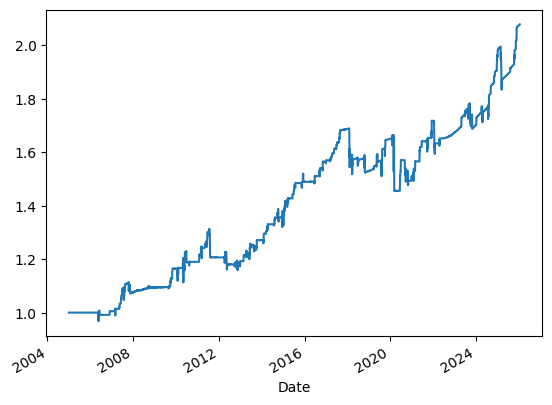

In [30]:
res.equity_net.plot()